<a href="https://colab.research.google.com/github/bislara/Blood-Cell-Classification/blob/master/Blood_Cell_Classification_PyTorch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import os
import time


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.ImageFolder(root = "/content/drive/My Drive/Blood_cells_dataset/TRAIN", transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4)

testset = torchvision.datasets.ImageFolder(root = "/content/drive/My Drive/Blood_cells_dataset/TEST", transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=4)

testsample = torchvision.datasets.ImageFolder(root = "/content/drive/My Drive/Blood_cells_dataset/TEST_SIMPLE", transform = transform)
test_sample_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=4)


In [0]:
root_path = '/content/drive/My Drive/Blood_cells_dataset/TRAIN'
file_names = []
dir_names = []
root_names = []
for (root,dirs,files) in os.walk(root_path, topdown=True):
    file_names.append(files)
    dir_names.append(dirs)
    root_names.append(root)

classes = tuple(dir_names[0])


In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

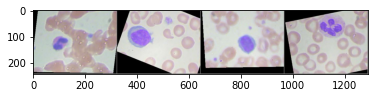

LYMPHOCYTE NEUTROPHIL NEUTROPHIL EOSINOPHIL
Input Size is  torch.Size([4, 3, 240, 320])


In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
print("Input Size is ",images.size())

In [0]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, in_fea = 3, out_fea = len(classes)):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_fea, 6, 5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 230 * 310, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, out_fea)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        #print("X size is: ",x.size())
        x = x.view(-1, 16 * 230 * 310)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [0]:
#check if cuda available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

step = 0
loss_train = []
loss_val = []

#import the model
net = Net()
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  net = nn.DataParallel(net)
net = net.to(device)


In [8]:
print(device)

cuda:0


In [0]:
net = net.train()
min_loss = 100
patience = 15
training_loss_store = []
validation_loss_store = []

import torch.optim as optim

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
file = open('/content/drive/My Drive/Blood_cells_dataset/logs_test4_epoch100_with_max_pool2.txt', 'w')


In [23]:
print('training started.............................................')
file.write('training started.............................................\n')
start_time = time.time()
for epoch in range(50):  # loop over the dataset multiple times
    file.write('##############################TRAINING###############################\n')
    running_loss = 0.0
    loop_no=0
    for i, data in enumerate(trainloader, 0):
        step+=1
        loop_no+=1
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        #print("Input Size is ",inputs.size())
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss_train.append(loss.item())
        training_loss_store.append([epoch, loss.item()])
        loss.backward()
        optimizer.step()
        

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 10))
            #log_loss_summary(logger, loss_train, step, prefix = 'train_')
            file.write('epoch = '+ str(epoch + 1) + '\t' +'step = '+ str(step) +'\t'+'train_loss = '+'\t'+str(np.mean(loss_train)) +'\n')
            loss_train = []
            running_loss = 0.0
            
    print('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time))
    file.write('Finished training for epoch ' + str(epoch) + ' time taken = ' + str(time.time() - start_time) + '\n')
    file.write('##################################evaluation##############################\n')
    print('################################evaluation###########################\n')
    

    with torch.no_grad():
        val_loss = 0
        net.eval()
        
        for i, data in enumerate(test_sample_loader, 0):
            step+=1
            inputs, labels = data[0].to(device),data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss_val.append(loss.item())
            validation_loss_store.append([epoch, loss.item()])
            val_loss += loss
            
        val_loss = val_loss/float(i + 1)
        
        if val_loss < min_loss:
            min_loss = val_loss
            no_impr_epoch = 0
            
            #save the best model
            torch.save(net.state_dict(), 'training/epoch_' + str(epoch+1) + 'loss_' + str(val_loss) + '.pt')
            
            print('performance improved with validation loss ' + str(val_loss))
            file.write('--------------------------------------------------------------------\n')
            file.write('performance improved with validation loss =  ' + str(val_loss) + '\n')
            
            file.write('epoch = '+ str(epoch + 1) + '\t' +'step = '+ str(step) +'\t'+'val_loss = '+'\t'+str(np.mean(loss_val)) +'\n')
            file.write('--------------------------------------------------------------------\n\n')
            #log_loss_summary(logger, loss_val, step, prefix="val_")
            loss_val = []
        else:
            no_impr_epoch += 1
            print('no improvement with prev best model ' + str(no_impr_epoch) + 'th')
            file.write('no improvement with prev best model ' + str(no_impr_epoch) + 'th \n')
            
        if no_impr_epoch > patience:
            print('stop training')
            file.write('stop training')
            break

print('Finished Training................................................')
file.write('Finished Training................................................\n')
end_time = time.time()
file.write('Training time:- ' + str(end_time - start_time))
file.close()


Streaming output truncated to the last 5000 lines.
[1,   640] loss: 1.385
[1,   650] loss: 1.387
[1,   660] loss: 1.386
[1,   670] loss: 1.393
[1,   680] loss: 1.383
[1,   690] loss: 1.386
[1,   700] loss: 1.382
[1,   710] loss: 1.378
[1,   720] loss: 1.384
[1,   730] loss: 1.400
[1,   740] loss: 1.370
[1,   750] loss: 1.392
[1,   760] loss: 1.384
[1,   770] loss: 1.395
[1,   780] loss: 1.393
[1,   790] loss: 1.392
[1,   800] loss: 1.386
[1,   810] loss: 1.371
[1,   820] loss: 1.380
[1,   830] loss: 1.396
[1,   840] loss: 1.400
[1,   850] loss: 1.383
[1,   860] loss: 1.388
[1,   870] loss: 1.386
[1,   880] loss: 1.386
[1,   890] loss: 1.381
[1,   900] loss: 1.387
[1,   910] loss: 1.386
[1,   920] loss: 1.384
[1,   930] loss: 1.386
[1,   940] loss: 1.386
[1,   950] loss: 1.389
[1,   960] loss: 1.387
[1,   970] loss: 1.385
[1,   980] loss: 1.393
[1,   990] loss: 1.385
[1,  1000] loss: 1.369
[1,  1010] loss: 1.392
[1,  1020] loss: 1.391
[1,  1030] loss: 1.390
[1,  1040] loss: 1.371
[1,  1

In [0]:
#Release all unoccupied cached memory in GPU
if(torch.cuda.is_available()):
    torch.cuda.empty_cache()


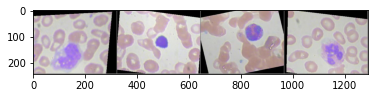

Ground Truth:  MONOCYTE NEUTROPHIL LYMPHOCYTE EOSINOPHIL
Predicted:  MONOCYTE NEUTROPHIL NEUTROPHIL EOSINOPHIL
LYMPHOCYTE :-  -4.3647885
NEUTROPHIL :-  -0.409612
MONOCYTE :-  3.0854611
EOSINOPHIL :-  -3.097486


In [25]:
PATH = "training/epoch_4loss_tensor(1.0084, device='cuda:0').pt"
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
i = outputs.detach().numpy()
#print('Scores:-', i)
for j in range(len(classes)):
    print(classes[j], ':- ', i[0, j])

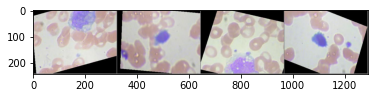

Ground Truth:  MONOCYTE NEUTROPHIL MONOCYTE NEUTROPHIL
Predicted:  MONOCYTE NEUTROPHIL MONOCYTE NEUTROPHIL
LYMPHOCYTE :-  -8.794403
NEUTROPHIL :-  -1.3650838
MONOCYTE :-  7.2073483
EOSINOPHIL :-  -4.5455403


In [26]:
PATH = "training/epoch_4loss_tensor(1.0084, device='cuda:0').pt"
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

dataiter = iter(trainloader)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
i = outputs.detach().numpy()
#print('Scores:-', i)
for j in range(len(classes)):
    print(classes[j], ':- ', i[0, j])

In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0], data[1]
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print("Total is ",total)

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))


Total is  4
Total is  8
Total is  12
Total is  16
Total is  20
Total is  24
Total is  28
Total is  32
Total is  36
Total is  40
Total is  44
Total is  48
Total is  52
Total is  56
Total is  60
Total is  64
Total is  68
Total is  72
Total is  76
Total is  80
Total is  84
Total is  88
Total is  92
Total is  96
Total is  100
Total is  104
Total is  108
Total is  112
Total is  116
Total is  120
Total is  124
Total is  128
Total is  132
Total is  136
Total is  140
Total is  144
Total is  148
Total is  152
Total is  156
Total is  160
Total is  164
Total is  168
Total is  172
Total is  176
Total is  180
Total is  184
Total is  188
Total is  192
Total is  196
Total is  200
Total is  204
Total is  208
Total is  212
Total is  216
Total is  220
Total is  224
Total is  228
Total is  232
Total is  236
Total is  240
Total is  244
Total is  248
Total is  252
Total is  256
Total is  260
Total is  264
Total is  268
Total is  272
Total is  276
Total is  280
Total is  284
Total is  288
Total is  292
Tota

In [28]:
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0], data[1]
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        for i in range(1):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

#file = open('result_logs.txt', 'w')
for i in range(4):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    #file.write('Accuracy of' + classes[i] + ':' + '\t' + str(100 * class_correct[i] / class_total[i]) +'%'+'\n')
    

Accuracy of LYMPHOCYTE : 43 %
Accuracy of NEUTROPHIL : 56 %
Accuracy of MONOCYTE : 87 %
Accuracy of EOSINOPHIL : 49 %


In [0]:
file.close()

In [0]:
torch.save(net.state_dict(), 'model.pt')